## LSTM Autoencoder: Learning time-series to predict pathologic ECG activity

Script perpared by Nikolas Weissmueller, for CS230 final project.

This projects leveraged the following sources:    
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html   
https://github.com/shobrook/sequitur    
https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

In [ ]:
import zipfile

with zipfile.ZipFile('ECG5000.zip', 'r') as zip_ref:
    zip_ref.extractall('/mnt')

#### Load project libraries and settings

In [1]:
# import standard libs
import numpy as np
import pandas as pd
from scipy.io import arff
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import copy

# import sklearn functionality
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, average_precision_score, confusion_matrix

# import pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F

# configure layout
%matplotlib inline
%config InlineBackend.figure_format='retina'

# plot settings
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS_PALETTE=["#FF006D","#808080"]
sns.set_palette(sns.color_palette(COLORS_PALETTE))

# randomization settings
RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!nvidia-smi

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Sep 17 18:35:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------

## Define functions

### Build the LSTM Autoencoder

The autoencoder learns a compressed and simplified representation of the data, and it will aim to reconstruct from lower dimensionality. The LSTM-AE model (encoder, decoder, LSTM-AE, train_model, predict, and plot_prediction) were adapted from: https://github.com/shobrook/sequitur and further adapted from: https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

In [4]:
class encoder(nn.Module):
    """
    encoder: initializes 3 LSTM RNNs, with input size and hidden size as
    function of embedding dimension.

    forward: implements forward pass through rnn layers

    output: hidden layer values of the encoder output
    """

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim1, self.hidden_dim2 = embedding_dim, 2 * embedding_dim, 4 * embedding_dim

        # first LSTM layer
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim2,
            num_layers=1,
            batch_first=True
        )

        # second LSTM layer
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim2,
            hidden_size=self.hidden_dim1,
            num_layers=1,
            batch_first=True
        )

        # third LSTM layer
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim1,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (_, _) = self.rnn2(x)
        x, (hidden_n, _) = self.rnn3(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [5]:
class decoder(nn.Module):
    """
    decoder: initializes 3 LSTM RNNs, with input size and hidden size as
    function of embedding dimension and 1 linear layer that generates a 1-dim vector

    forward: implements forward pass through rnn layers and linear layer

    output: 1-dimensional reconstructed values from encoder input
    """

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim1, self.hidden_dim2, self.n_features = 2 * input_dim, 4 * input_dim, n_features

        # first LSTM layer
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        # second LSTM layer
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim1,
            num_layers=1,
            batch_first=True
        )

        # third LSTM layer
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim1,
            hidden_size=self.hidden_dim2,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim2, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x, (hidden_n, cell_n) = self.rnn3(x)
        x = x.reshape((self.seq_len, self.hidden_dim2))

        return self.output_layer(x)

In [6]:
class LSTM_AE(nn.Module):
    """
    Initializes encoder and decoder with given dimensions on device.

    forward: implements forward pass of input through encoder and decoder

    output: returns decoder output
    """

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTM_AE, self).__init__()
        self.encoder = encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [7]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    """
    Trains model over n_epochs, keeps best model weights. Initializes optimizer, criterion,
    and model history dictionary.

    input: model architecture, taining dataset (normal cases), validation dataset (normal cases)
    number of epochs.

    outputs: trained model, and model training and validation error dictionary
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []

        # compute trainingset loss
        for seq in train_dataset:
            optimizer.zero_grad()
            seq = seq.to(device)
            seq_pred = model(seq)
            loss = criterion(seq_pred, seq)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # compute validation set loss
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq in val_dataset:
                seq = seq.to(device)
                seq_pred = model(seq)
                loss = criterion(seq_pred, seq)
                val_losses.append(loss.item())

        # compute mean training and validation loss and add to dict
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        # keep model weights if validation loss is lower than best previous value
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        if epoch == 1 or epoch % 10 == 0:
            print(f'Epoch {epoch}: train loss {train_loss:.5f} val loss {val_loss:.5f}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [8]:
def predict(model, dataset):
    """
    Generates predictions by applying the model to a dataset

    input: trained LSTM-model, time-series dataset
    output: predicted values, and cumulative L1 loss for the time-series
    """
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)

    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())

    return predictions, losses

In [9]:
def plot_prediction(data, model, title, ax):
    """
    Plots predicted vs. actual time-series per graph

    input: LSTM-AE model, time-series dataset, title and axis
    output: plot
    """

    predictions, pred_losses = predict(model, [data])
    ax.plot(predictions[0], label='reconstructed')
    ax.plot(data, label='true')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

In [10]:
def create_dataset(df):
    """
    Creates stacked torch tensor from numpy df and returns dimensions.

    input: dataframe
    output: number of sequences, sequence length, number of features
    """

    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [11]:
def normalize_loss(losses, THRESHOLD = 1):
    """
    Rescales cumulative L1 loss to range 0 to 1 relative to threshold,
    such that values below the manually selected threshold maps to 0.5 - 1.0
    and values above to 0.0 -0.5

    input: losses, manually selected threshold
    output: normalized loss
    """
    norm_x = list()
    x_min = np.min(losses)
    x_max = np.max(losses)
    for loss in losses:
        if loss >= THRESHOLD:
            # scale above, relative to threshold
            x = 0.5 * (loss - THRESHOLD) / (x_max - THRESHOLD)
        else:
            # scale below, relativce to threshold
            x = 1 - 0.5 * (loss - x_min) / (THRESHOLD - x_min)
        norm_x.append(x)
    return norm_x

In [12]:
def reset_model(model):
    """
    Resets the LSTM-AE model weights to enable de-novo model training

    input: LSTM-AE model
    """

    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [13]:
def loss_to_prob(norm_losses_pos, norm_losses_neg):
    """
    Converts 0-1 normalized cumulative L1 loss per time-series and approximates
    probabilities by scaling loss relative to threshold.

    Returns y_predicted and y_test values for ROC curve
    """

    y_predicted_pos = norm_losses_pos
    y_test_pos = np.ones(len(y_predicted_pos))
    y_predicted_neg = norm_losses_neg
    y_test_neg = np.zeros(len(y_predicted_neg))
    y_predicted_np = np.concatenate((np.array(y_predicted_pos), np.array(y_predicted_neg)), axis=0)
    y_test_np = np.concatenate((y_test_pos, y_test_neg), axis=0)
    a = torch.from_numpy(y_predicted_np)
    b = torch.from_numpy(y_test_np)

    return a.reshape(len(y_predicted_np),1), b.reshape(len(y_test_np),1)

## Load data and build train, dev, and test sets

In [14]:
with open('ECG5000_TRAIN.arff', 'r') as f:
  data, meta = arff.loadarff(f)
  train = pd.DataFrame(data)

with open('ECG5000_TEST.arff', 'r') as f:
  data, meta = arff.loadarff(f)
  test = pd.DataFrame(data)

In [16]:
# Concatenate train and test DataFrames
df = pd.concat([train, test])

# Shuffle the DataFrame
df = df.sample(frac=1.0)

In [17]:
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df['target'] = df['target'].str.decode('utf-8').astype(int)
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

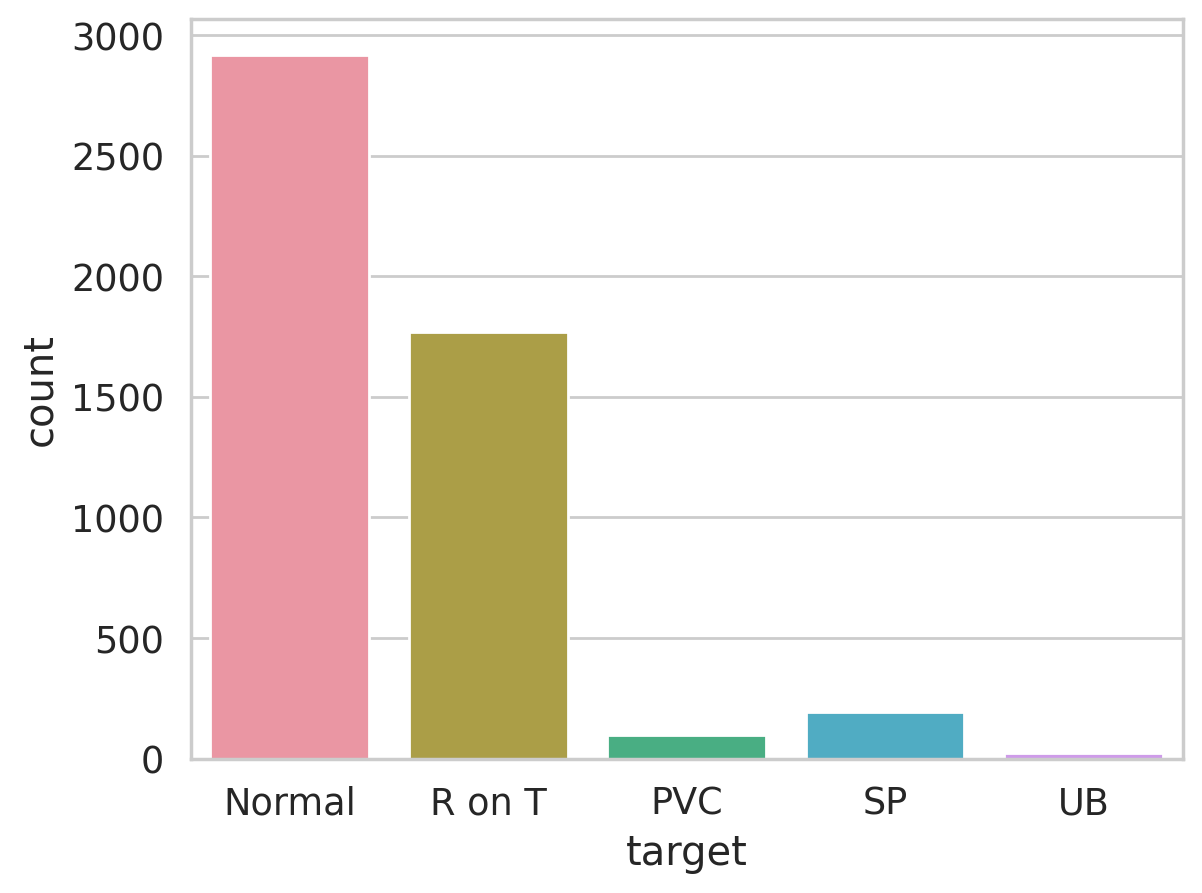

In [19]:
# Visualize data
ax = sns.countplot(x='target', data=df)
ax.set_xticklabels(class_names)

#### Generate "normal" and "anomalous" training dataset

In [20]:
normal_df = df[df['target'] == CLASS_NORMAL].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [21]:
anomaly_df = df[df['target'] != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

## Initialize and run the model

Cross-validation approach was adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

### Cross Validation and ROC-AUC
This section generates 10-fold cross validation for the LSTM-AE model.

Be sure to check and set n_splits for CV, embedding_dim for the LSTM-AE model, and n_epochs for the number extent of model training per data fold.

In [27]:
# initialize variables and lists
tprs = []
aucs = []
praucs = []
f1s = []
accs = []
mean_fpr = np.linspace(0, 1, 100)

# set parameters for 10-fold Cross Validation
fold = 0
kf = KFold(n_splits=10, random_state=None)
X = normal_df

# set cumulative L1-loss threshold to distinguish between "Healthy" and "Pathologic" wavelets
THRESHOLD = 27

# loop over CV folds
for train_index, test_index in kf.split(X):
    fold += 1

    # split "normal" dataset further into train and validation set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    train_df, val_df = train_test_split(
        X_train,
        test_size=0.20,
        random_state=RANDOM_SEED
    )

    # create datasets
    train_dataset, seq_len, n_features = create_dataset(train_df)
    val_dataset, _, _ = create_dataset(val_df)
    test_normal_dataset, _, _ = create_dataset(X_test)
    test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

    # initialize the model
    model = LSTM_AE(seq_len, n_features, embedding_dim=128)
    
    # reset the model
    reset_model(model)
    
    # send to device
    model = model.to(device)

    # train model
    print(f'Fold: {fold}')
    model, history = train_model(
        model,
        train_dataset,
        val_dataset,
        n_epochs=200
        )

    # evaluate positive case
    _, pred_losses_pos = predict(model, test_normal_dataset)
    norm_losses_pos = normalize_loss(pred_losses_pos, THRESHOLD)

    # evaluate negative case
    anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
    _, pred_losses_neg = predict(model, anomaly_dataset)
    norm_losses_neg = normalize_loss(pred_losses_neg, THRESHOLD)

    # reshape vectors components
    y_predicted, y_test = loss_to_prob(norm_losses_pos, norm_losses_neg)
    
    # compute ROC plot
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted)

    # conpute ROC curve and other metrics
    roc_auc = auc(fpr, tpr)
    y_predicted_cls = y_predicted.round()
    pr_auc = average_precision_score(y_test, y_predicted_cls)
    f1 = f1_score(y_test, y_predicted_cls, zero_division=1)
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    

    # collect CV fold data
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    praucs.append(pr_auc)
    f1s.append(f1)
    accs.append(acc)
    
    # Print the metrics
    print(f'F1 = {f1:.4f}')
    print(f'ROC AUC = {roc_auc:.4f}')
    print(f'Acc = {acc:.4f}')

Fold: 1
Epoch 1: train loss 68.16271 val loss 58.09570
Epoch 10: train loss 33.87199 val loss 30.17282
Epoch 20: train loss 22.16960 val loss 20.79100
Epoch 30: train loss 18.01996 val loss 18.43201
Epoch 40: train loss 14.31269 val loss 13.40784
Epoch 50: train loss 13.01883 val loss 12.90336
Epoch 60: train loss 12.01011 val loss 11.64714
Epoch 70: train loss 11.40436 val loss 11.18302
Epoch 80: train loss 10.73114 val loss 11.81417
Epoch 90: train loss 10.35604 val loss 11.08685
Epoch 100: train loss 10.00129 val loss 11.81248
Epoch 110: train loss 9.77332 val loss 9.99540
Epoch 120: train loss 9.39646 val loss 11.49614
Epoch 130: train loss 9.50230 val loss 11.68338
Epoch 140: train loss 9.12123 val loss 10.02088
Epoch 150: train loss 8.97509 val loss 11.97737
Epoch 160: train loss 8.84065 val loss 10.54190
Epoch 170: train loss 8.75542 val loss 9.78892
Epoch 180: train loss 8.59225 val loss 10.77875
Epoch 190: train loss 8.40173 val loss 9.72177
Epoch 200: train loss 8.40701 val l

## Visualizations

####  Model training and validation loss vs. number of epochs

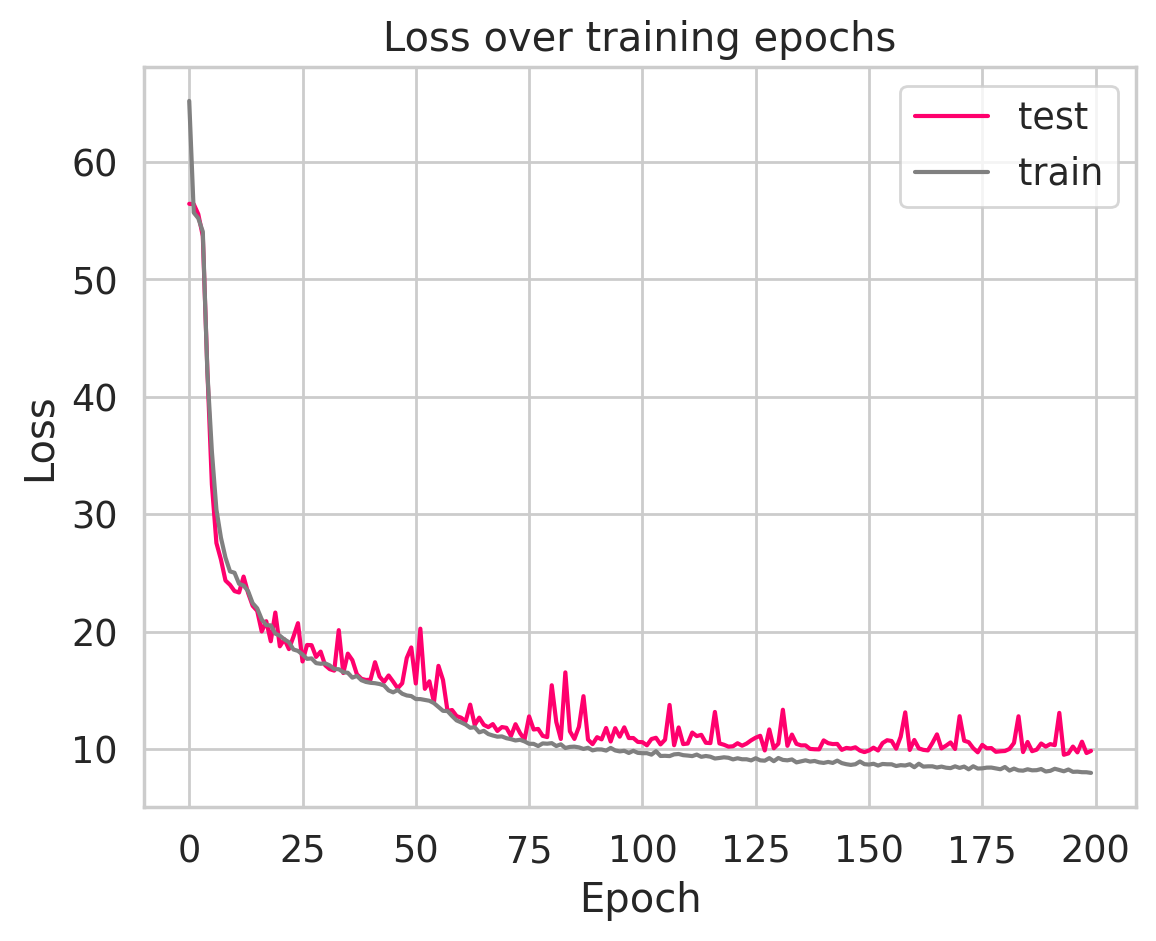

In [28]:
ax = plt.figure().gca()
ax.plot(history['val'])
ax.plot(history['train'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['test', 'train'])
plt.title('Loss over training epochs')
plt.show();

#### Print LSTM-AE model dimensions

In [29]:
print(model)

LSTM_AE(
  (encoder): encoder(
    (rnn1): LSTM(1, 512, batch_first=True)
    (rnn2): LSTM(512, 256, batch_first=True)
    (rnn3): LSTM(256, 128, batch_first=True)
  )
  (decoder): decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (rnn3): LSTM(256, 512, batch_first=True)
    (output_layer): Linear(in_features=512, out_features=1, bias=True)
  )
)


#### Save or restore the model (uncomment to use)

In [30]:
# MODEL_PATH = "/mnt/trained_model_v2"
# torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# to restore:
# model.load_state_dict(torch.load(filepath))
# model.eval()

### Selecting a threshold

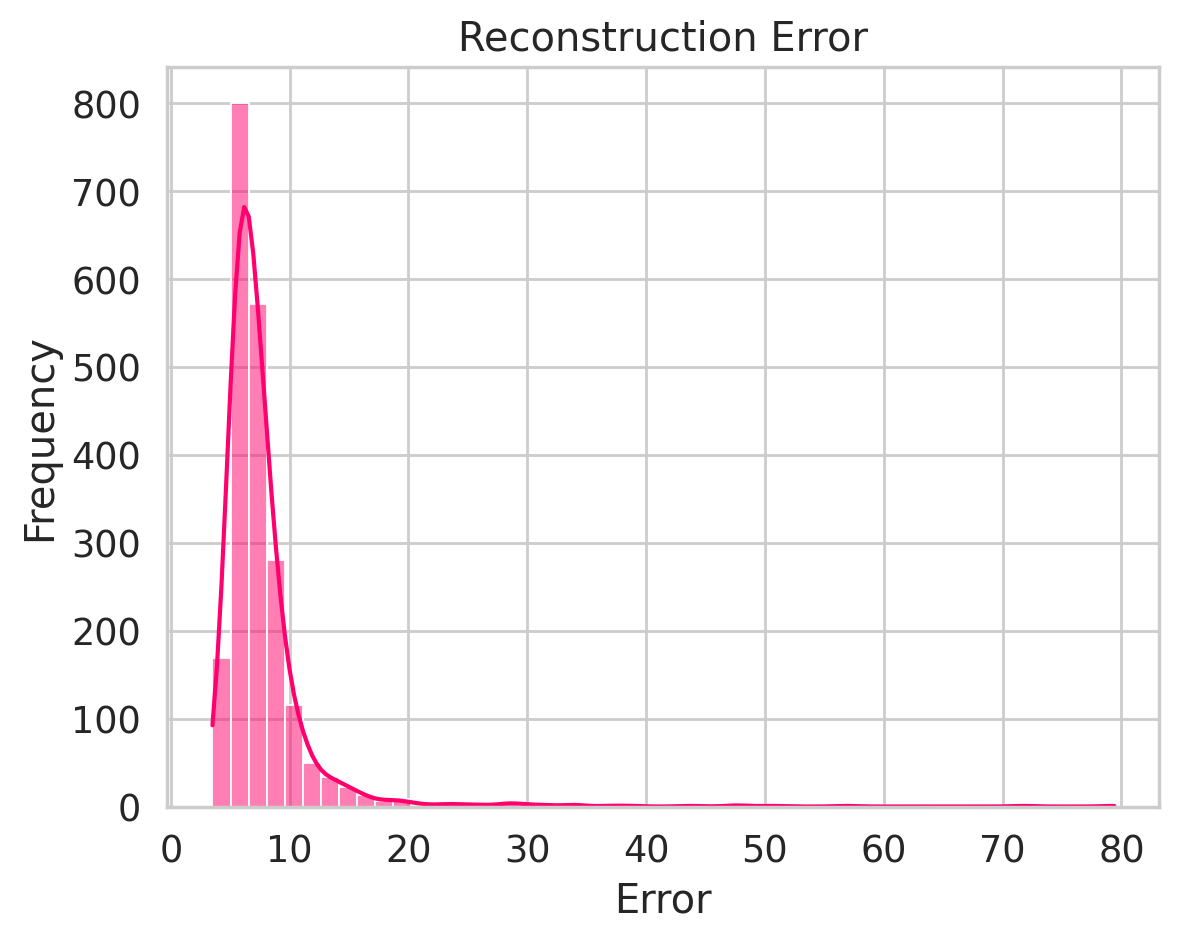

In [80]:
_, losses = predict(model, train_dataset)

sns.histplot(losses, bins=50, kde=True)
plt.ylabel('Frequency')
plt.xlabel('Error')
plt.title('Reconstruction Error');

In [32]:
# select threshold such that most reconstuction error iterations are lower
THRESHOLD = 27

#### Predictions: Group A

Correct normal predictions: 281/291


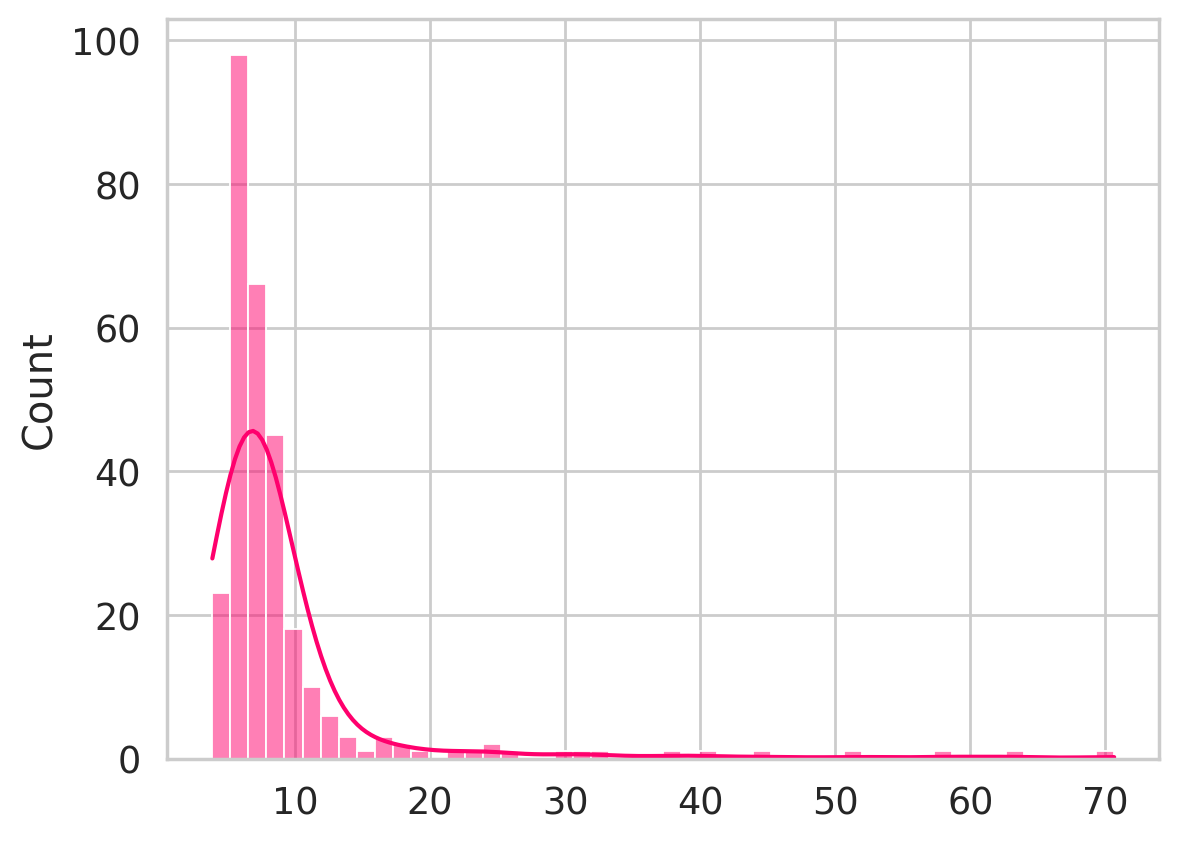

In [79]:
predictions, pred_losses = predict(model, test_normal_dataset)
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')
sns.histplot(pred_losses, bins=50, kde=True);

#### Predictions: Group B

In [34]:
anomaly_dataset_sub = test_anomaly_dataset[:len(test_normal_dataset)]

Correct anomaly predictions: 291/291


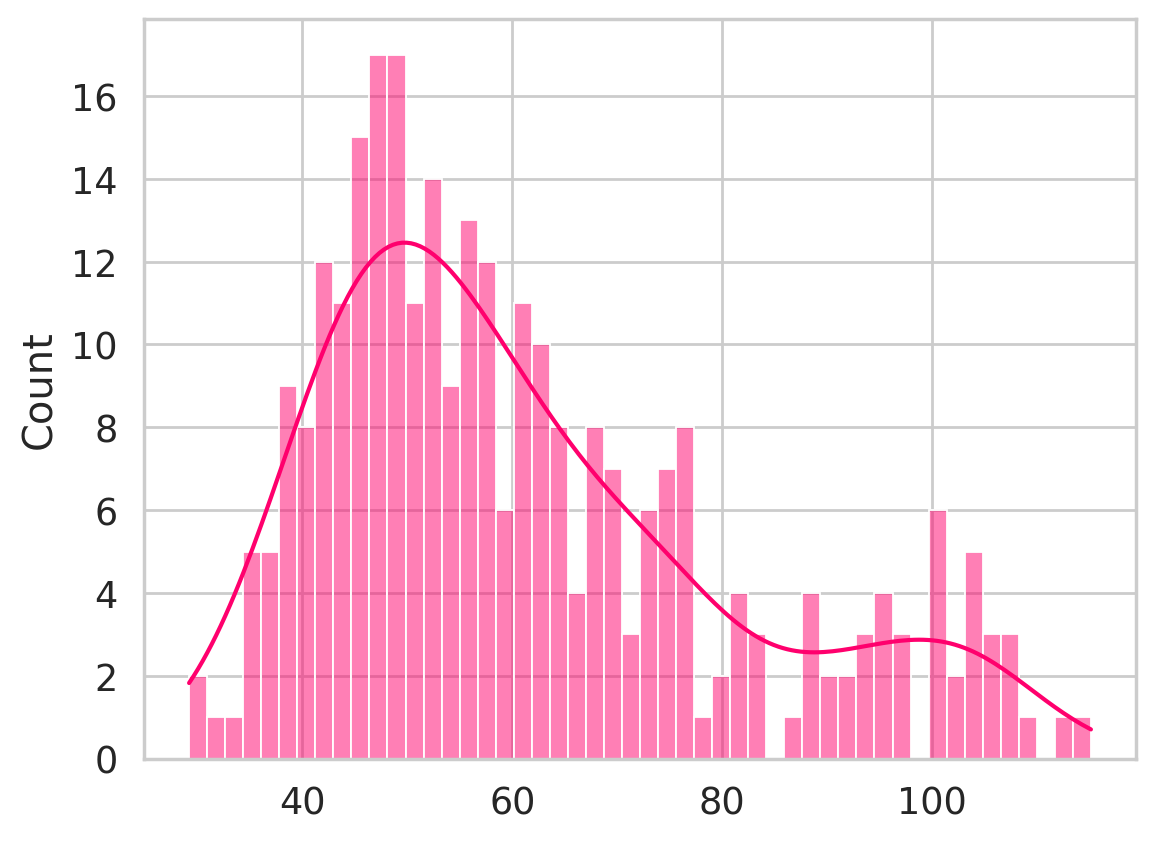

In [78]:
predictions, pred_losses = predict(model, anomaly_dataset_sub)
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')
sns.histplot(pred_losses, bins=50, kde=True);

### Visualize actual vs. reconstructed examples

Adapted from: https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

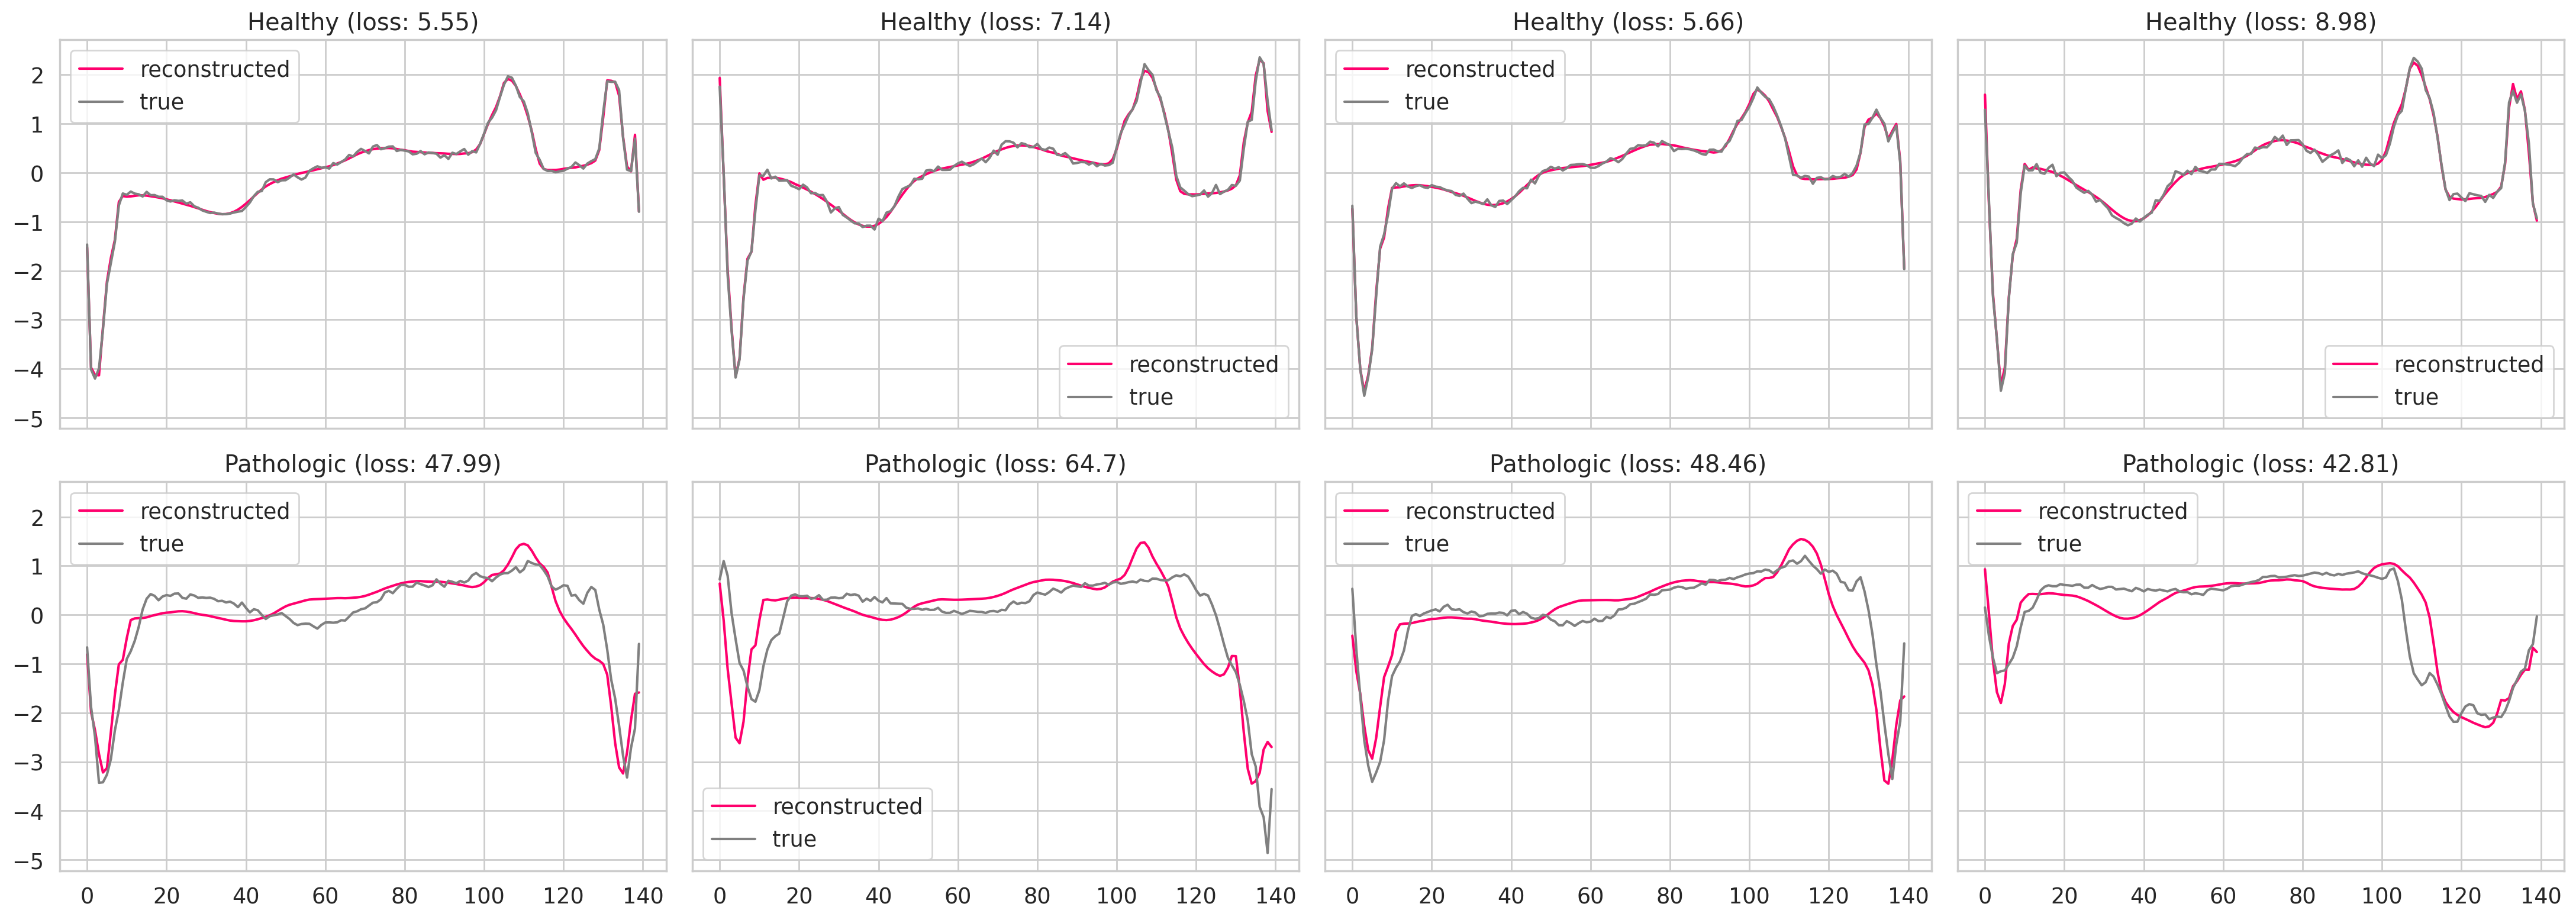

In [36]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    sharey=True,
    sharex=True,
    figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
    plot_prediction(data, model, title='Healthy', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
    plot_prediction(data, model, title='Pathologic', ax=axs[1, i])

fig.tight_layout();


#### Normalize losses and compute confusion matrix and model performance

In [37]:
# normal wavelets
_, pred_losses_pos = predict(model, test_normal_dataset)
norm_losses_pos = normalize_loss(pred_losses_pos)

# anomalous wavelets
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
_, pred_losses_neg = predict(model, anomaly_dataset)
norm_losses_neg = normalize_loss(pred_losses_neg)

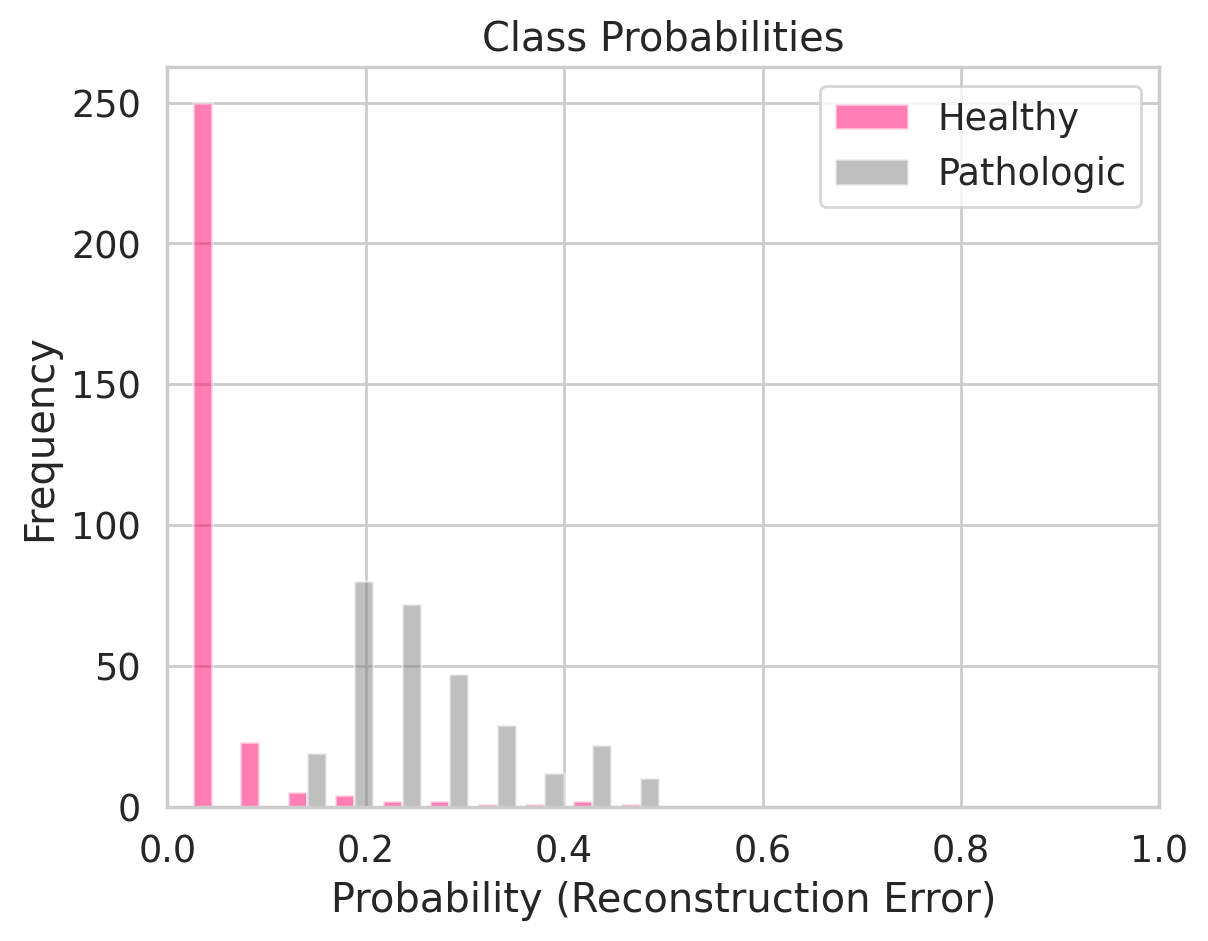

In [38]:
# overlay negatives and positives error distributions
plt.hist([norm_losses_pos, norm_losses_neg],
         color=[COLORS_PALETTE[0], COLORS_PALETTE[1]], alpha=0.5)
plt.xlim(0,1)
plt.ylabel('Frequency')
plt.xlabel('Probability (Reconstruction Error)')
plt.legend(['Healthy', 'Pathologic'])
plt.title('Class Probabilities');


### Generate ROC plot

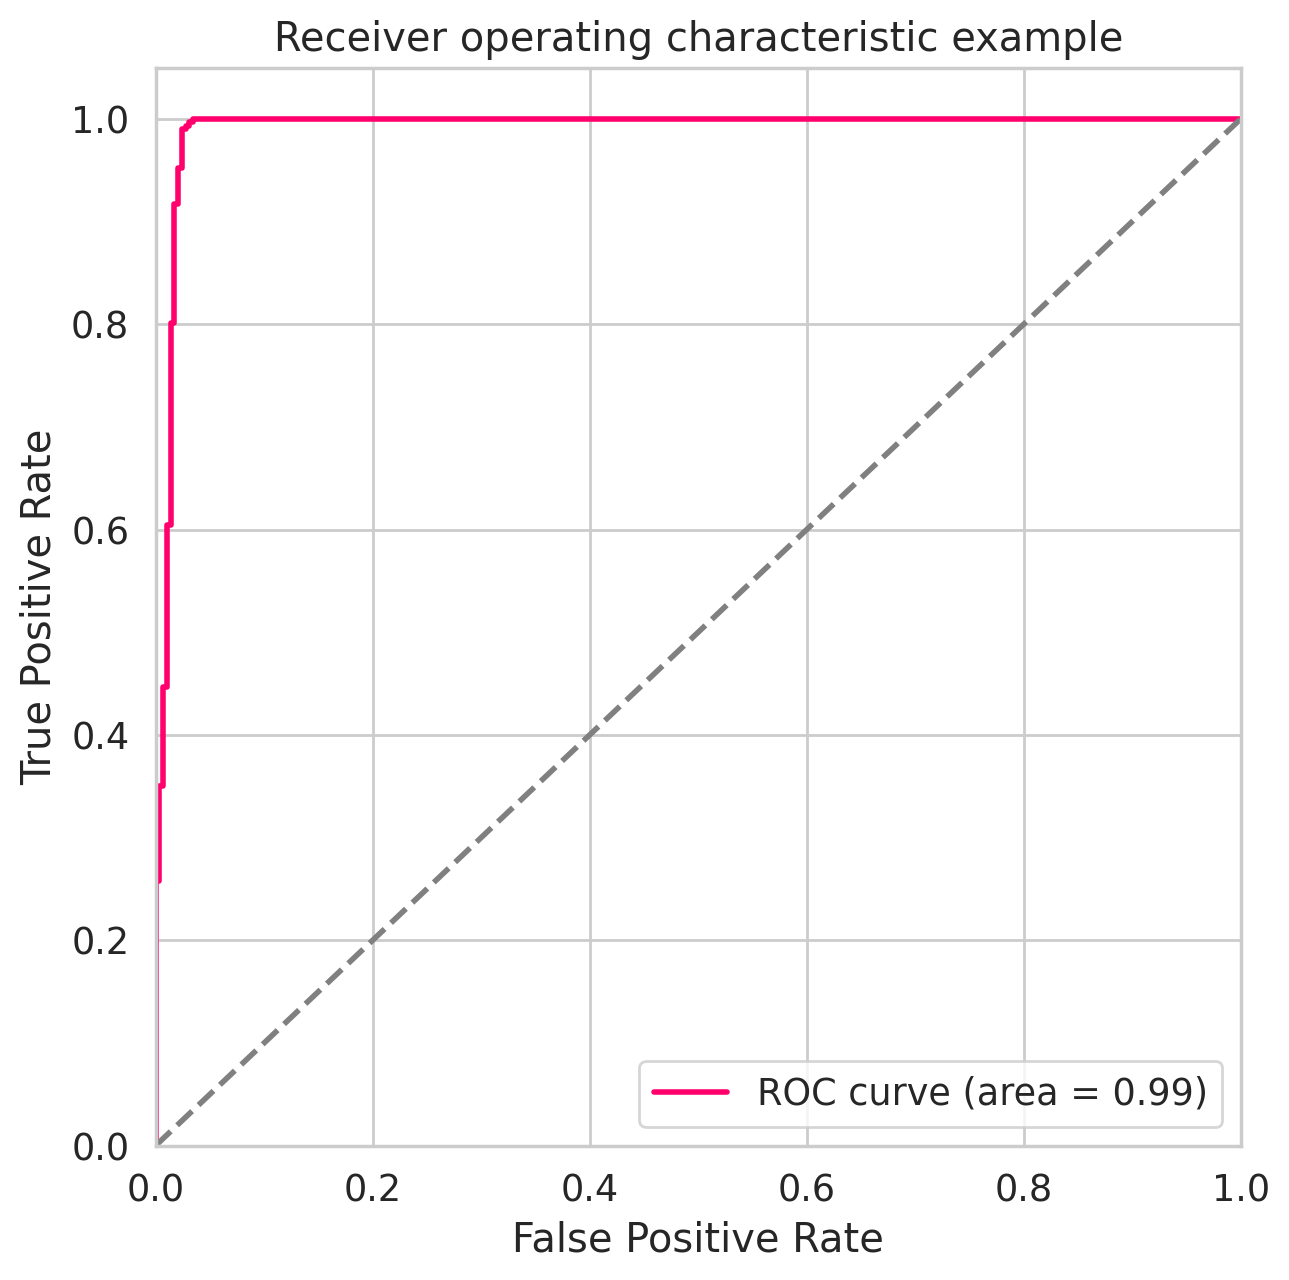

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

predictions_normal, pred_losses_normal = predict(model, test_normal_dataset)
predictions_anomaly, pred_losses_anomaly = predict(model, anomaly_dataset_sub)

# Step 1: Generate true labels
true_labels_normal = [0] * len(test_normal_dataset)  # Assuming 0 is the label for normal
true_labels_anomaly = [1] * len(anomaly_dataset_sub)  # Assuming 1 is the label for anomaly

# Step 2: Generate predicted labels based on threshold
pred_labels_normal = [(0 if l <= THRESHOLD else 1) for l in pred_losses_normal]
pred_labels_anomaly = [(0 if l <= THRESHOLD else 1) for l in pred_losses_anomaly]

# Step 3: Combine true labels and predicted labels
true_labels = true_labels_normal + true_labels_anomaly
pred_labels = pred_labels_normal + pred_labels_anomaly

# Step 5: Combine predicted losses from both normal and anomaly datasets to form the scores list
scores = pred_losses_normal + pred_losses_anomaly

# Step 6: Compute the ROC curve
fpr, tpr, _ = roc_curve(true_labels, scores)

# Step 7: Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Step 8: Plot the ROC curve
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color=COLORS_PALETTE[0], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color=COLORS_PALETTE[1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Generate Confusion Matrix

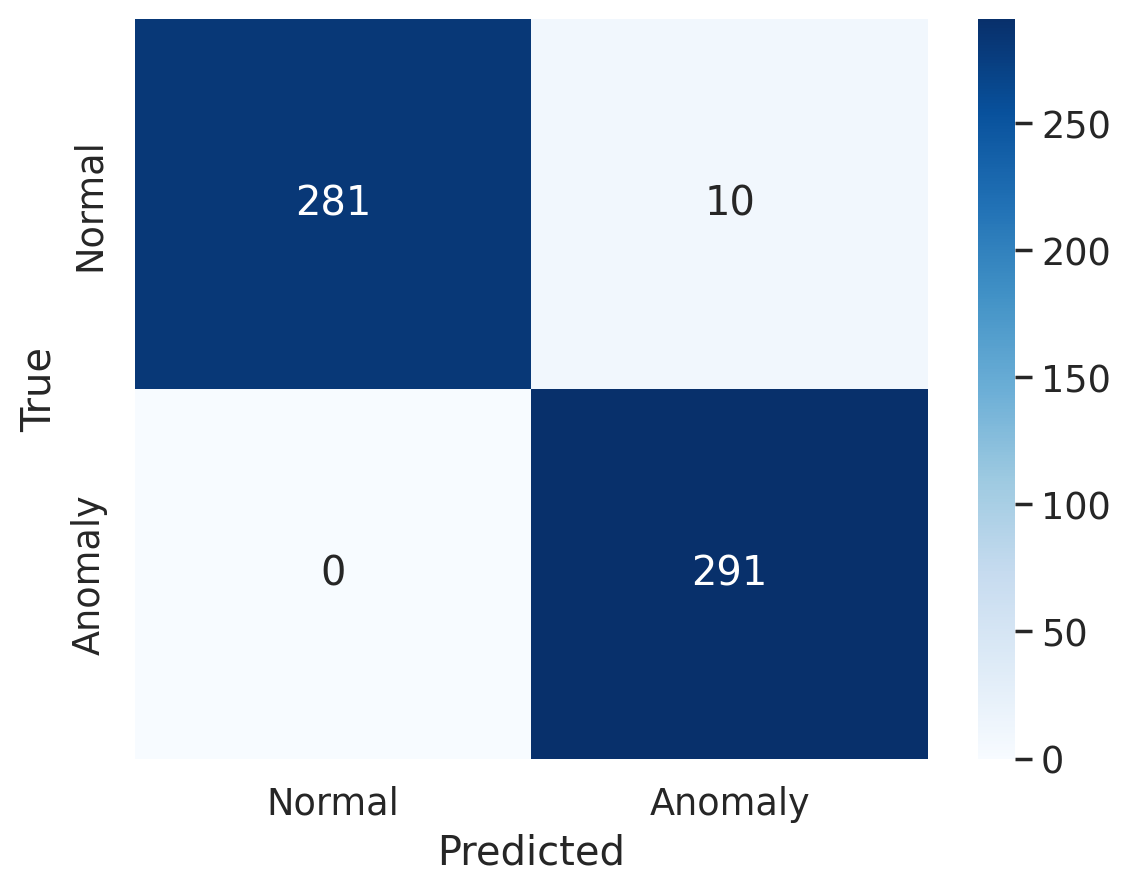

In [40]:
# Step 9: Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Step 10: Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Compute model performance metrics

In [41]:
# Step 5: Calculate metrics
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)
average_precision = average_precision_score(true_labels, pred_labels)

# Get the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc = auc(fpr, tpr)

# Print the metrics
print(f'ROC = {roc:.4f}')
print(f'F1 = {f1:.4f}')
print(f'ROC AUC = {roc_auc:.4f}')
print('PR AUC: {0:.4f}'.format(average_precision))

ROC = 0.9828
F1 = 0.9831
ROC AUC = 0.9828
PR AUC: 0.9668


In [42]:
print(f'Validation set shape: {val_df.shape}')
print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {y_test.shape}')

Validation set shape: (526, 140)
Training set shape: (2102, 140)
Test set shape: torch.Size([582, 1])


### Plot the 10-fold CV ROC Curve and average model performance metrics

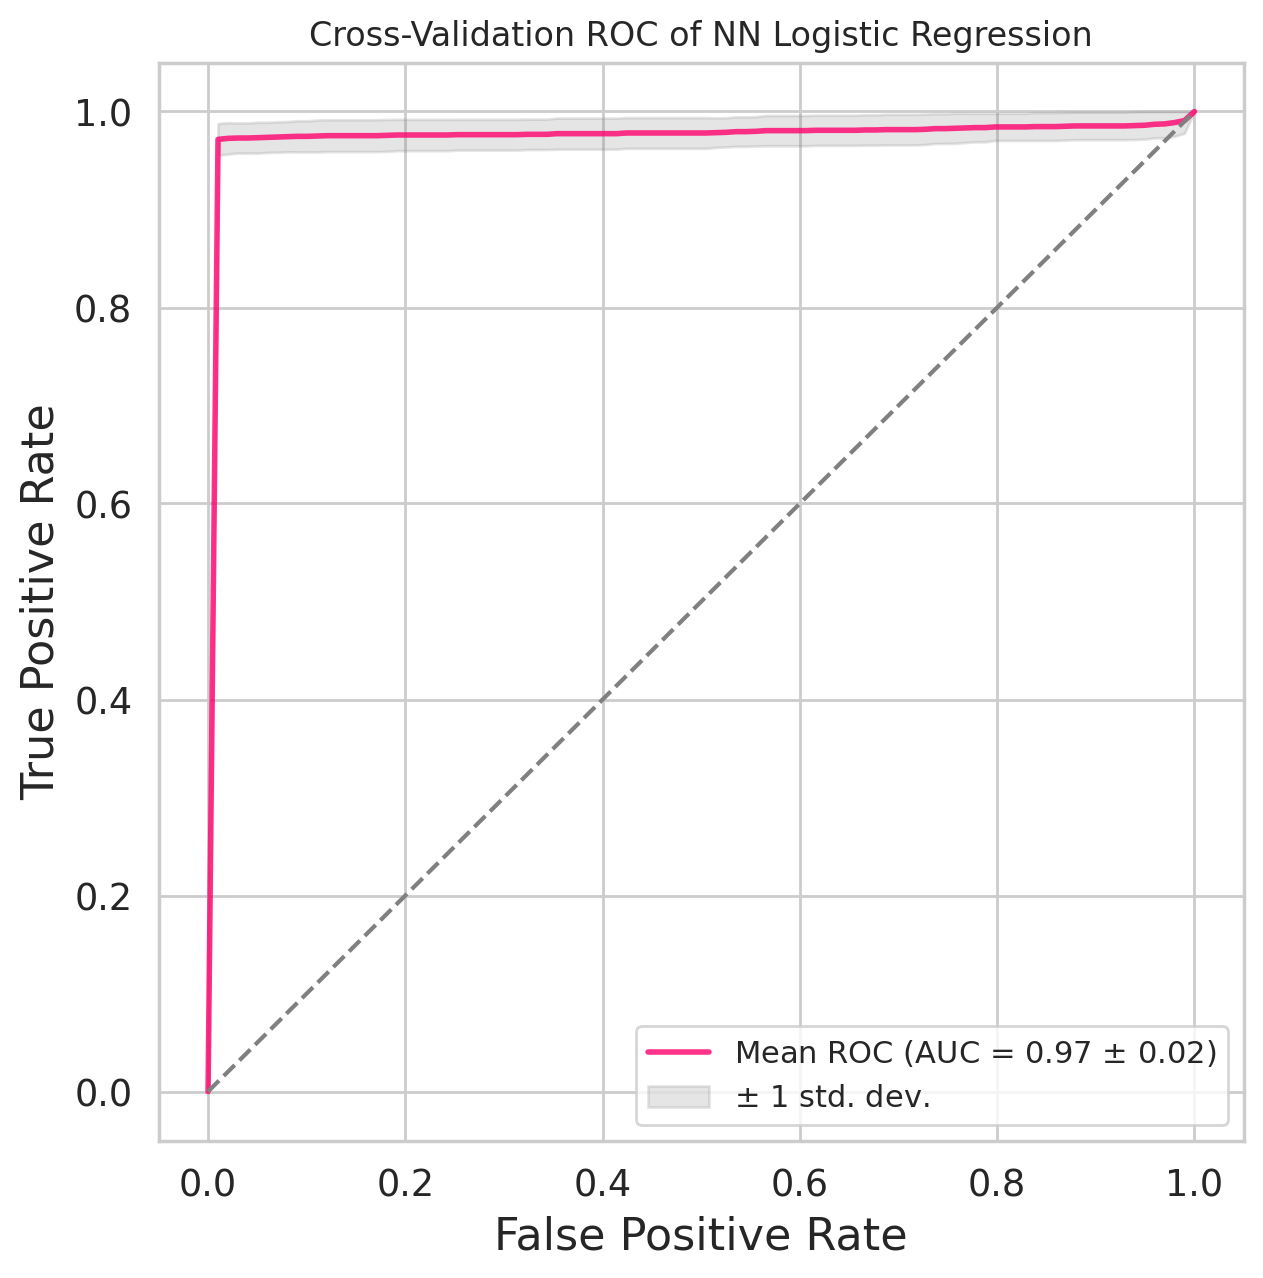

In [76]:
import matplotlib.pyplot as plt
import numpy as np

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

# Plot the mean ROC curve
plt.figure(figsize=(7,7))
plt.plot(mean_fpr, mean_tpr, color=COLORS_PALETTE[0], label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

# Plot the gray ribbon to indicate uncertainty
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

# Plot the dashed x=y line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.title('Cross-Validation ROC of NN Logistic Regression',fontsize=12)
plt.legend(loc="lower right", prop={'size': 11})
plt.show()

In [45]:
print(f'ROC AUC: {mean_auc:.2f}, \u00B1 {std_auc:.2f}')
print(f'PR AUC: {mean_prauc:.2f}, \u00B1 {std_prauc:.2f}')
print(f'Acc: {mean_acc:.2f}, \u00B1 {std_acc:.2f}')
print(f'F1 score: {mean_f1:.2f}, \u00B1 {std_f1:.2f}')

ROC AUC: 0.97, ± 0.02
PR AUC: 0.98, ± 0.01
Acc: 0.98, ± 0.01
F1 score: 0.98, ± 0.01


### END OF SCRIPT